In [103]:
import numpy as np
import pandas as pd

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk mengevaluasi performa model
from sklearn.metrics import f1_score, confusion_matrix

# Untuk melakukan ekstraksi data pada suatu kolom
import re 

# Membagi dataset menjadi train dan test set
from sklearn.model_selection import train_test_split

import time
import warnings
warnings.filterwarnings('ignore')

# Set rows ke 100 agar dapat melihat data lebih banyak
pd.set_option('display.max_rows', 100)

In [104]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler
from optuna.study import Study

In [105]:
X = pd.read_csv("train_features.csv")
y = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_features.csv")
test = test.drop(['ID'], axis=1)
submission_format = pd.read_csv("submission_format.csv")

In [106]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    # summ['top value'] = desc['top'].values
    # summ['Freq'] = desc['freq'].values

    return summ

In [107]:
summary(X).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,object,189,0,6,nan,nan,nan,nan
status_pernikahan,object,212,0,6,nan,nan,nan,nan
pendapatan,float64,190,0,3622,5073000.000000,332884000.000000,114483170.089606,43460423.969516
jumlah_anak_balita,float64,190,0,3,0.000000,2.000000,0.293080,0.473063
jumlah_anak_remaja,float64,204,0,3,0.000000,2.000000,0.353723,0.493014
terakhir_belanja,float64,172,0,113,0.000000,128.000000,47.231550,27.068512
belanja_buah,float64,181,0,2535,0.000000,396508.000000,59804.239824,74024.976109
belanja_daging,float64,178,0,2951,0.000000,3489675.000000,438574.823853,512042.740059
belanja_ikan,float64,193,0,2627,0.000000,621600.000000,81428.997792,99976.226855


In [108]:
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,object,204,0,6,nan,nan,nan,nan
status_pernikahan,object,182,0,6,nan,nan,nan,nan
pendapatan,float64,203,0,3610,2998899.000000,1305740000.000000,116324904.534716,51051222.459486
jumlah_anak_balita,float64,209,0,3,0.000000,2.000000,0.282904,0.465005
jumlah_anak_remaja,float64,210,0,3,0.000000,2.000000,0.355322,0.496865
terakhir_belanja,float64,201,0,116,0.000000,133.000000,47.181366,26.940287
belanja_buah,float64,186,0,2573,0.000000,408646.000000,61234.083425,76647.590617
belanja_daging,float64,195,0,2943,0.000000,3271191.000000,452848.379796,512320.643716
belanja_ikan,float64,196,0,2660,0.000000,574932.000000,85338.612093,103789.546199


In [109]:
train = pd.concat([X, y], axis=1)

In [110]:
train.sample(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
273,1968,Magister,Rencana Menikah,117164927.0,0.0,1.0,69.0,2059.0,90214.0,72.0,4592.0,1.0,2.0,11.0,0.0,NaN,3
1124,1949,NaN,NaN,101415589.0,0.0,0.0,63.0,193816.0,754006.0,255557.0,189774.0,0.0,4.0,9.0,0.0,NaN,3
2003,1978,SMA,Sendiri,54487153.0,0.0,0.0,61.0,53505.0,226637.0,67080.0,41739.0,1.0,5.0,4.0,0.0,NaN,1
3449,1967,Sarjana,Rencana Menikah,130880562.0,0.0,1.0,26.0,83468.0,201679.0,1936.0,87165.0,2.0,6.0,8.0,0.0,NaN,2
2582,1975,NaN,Menikah,151621433.0,0.0,0.0,62.0,65258.0,586076.0,NaN,NaN,1.0,7.0,9.0,0.0,NaN,4
2437,1955,Sarjana,Rencana Menikah,164384399.0,0.0,0.0,54.0,255390.0,1498007.0,89833.0,93140.0,0.0,1.0,8.0,0.0,NaN,4
359,1985,Sarjana,Rencana Menikah,81418000.0,1.0,0.0,93.0,4046.0,6069.0,8092.0,0.0,0.0,0.0,5.0,0.0,2013-08-15,0
2900,1970,SMP,Menikah,28133144.0,0.0,0.0,NaN,12027.0,NaN,42020.0,26012.0,0.0,0.0,3.0,0.0,NaN,2
1347,1966,Magister,Sendiri,97911806.0,0.0,0.0,79.0,172731.0,473171.0,111739.0,89012.0,1.0,8.0,11.0,0.0,NaN,6
3070,1991,SMA,Sendiri,104893200.0,NaN,NaN,31.0,68866.0,448366.0,62963.0,70834.0,7.0,7.0,3.0,0.0,NaN,4


Text(0, 0.5, 'Percentage')

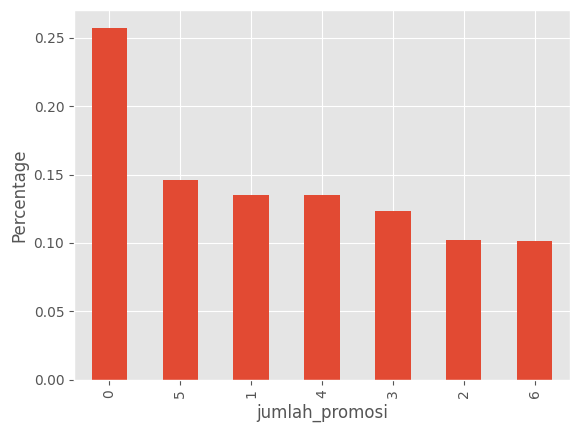

In [111]:
train['jumlah_promosi'].value_counts(normalize = True).plot(kind = 'bar')
plt.ylabel('Percentage')

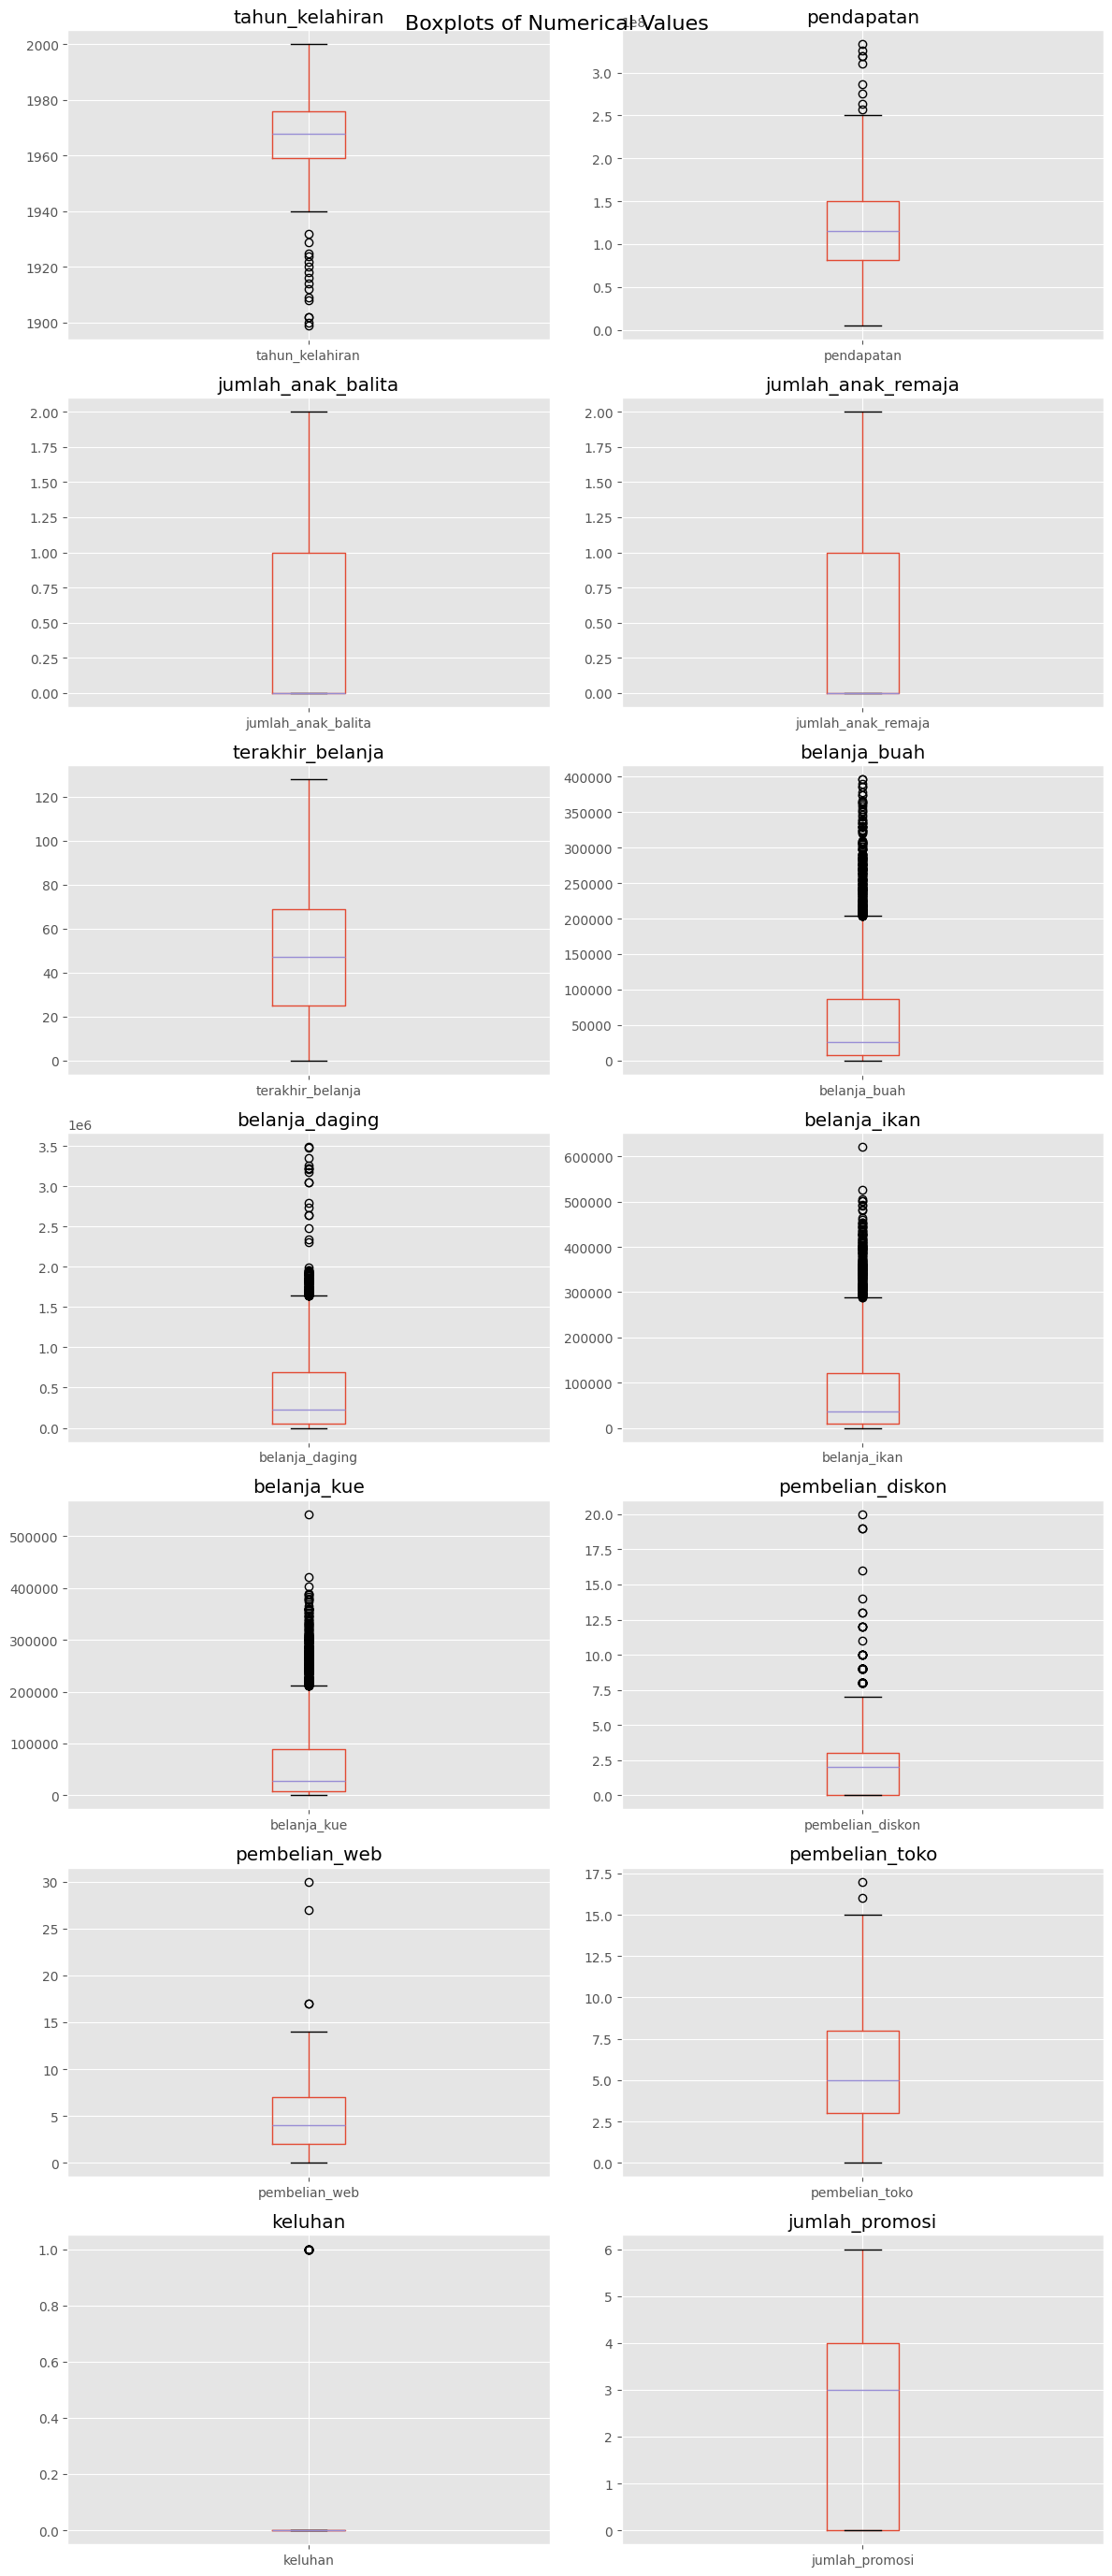

In [112]:
numerical_data = train.select_dtypes(include=[np.number])  # Select numerical columns

num_cols = numerical_data.shape[1]
num_rows = int(np.ceil(num_cols / 2))

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
fig.suptitle('Boxplots of Numerical Values', fontsize=16)

for i, column in enumerate(numerical_data.columns):
    ax = axes[i // 2, i % 2] if num_rows > 1 else axes[i % 2]
    numerical_data.boxplot(column=column, ax=ax)
    ax.set_title(column)
    

plt.tight_layout()
plt.show()

In [113]:
train.value_counts('pendidikan')

pendidikan
Sarjana     1841
Magister     856
SMA          435
Doktor       403
SMP           91
5              2
Name: count, dtype: int64

In [114]:
train.value_counts('status_pernikahan')

status_pernikahan
Rencana Menikah    1271
Menikah            1114
Sendiri             965
Cerai               214
Cerai Mati           40
5                     1
Name: count, dtype: int64

In [115]:
table = contingency_table = pd.crosstab(train['pendidikan'], train['jumlah_promosi'])
table

jumlah_promosi,0,1,2,3,4,5,6
pendidikan,,,,,,,
5,2,0,0,0,0,0,0
Doktor,162,54,37,62,10,43,35
Magister,170,91,71,148,126,159,91
SMA,119,63,76,44,55,45,33
SMP,47,10,18,9,0,0,7
Sarjana,424,271,170,195,301,289,191


### Preprocessing

In [116]:
def preprocessing(df):
    df = df.drop(['tanggal_menjadi_anggota','keluhan',], axis=1)
    df['pendidikan'] = df['pendidikan'].map({'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5})
    df['status_pernikahan'] = df['status_pernikahan'].map({'Sendiri': 1, 'Rencana Menikah': 2, 'Menikah': 3, 'Cerai': 4, 'Cerai Mati': 5})
    df['belanja_pokok'] = df['belanja_daging'] + df['belanja_ikan']
    df['belanja_non_pokok'] = df['belanja_kue'] + df['belanja_buah']
    # Pemeblian diatas 15 diubah jadi 15
    # df.loc[df['pembelian_web'] > 15, 'pembelian_web'] = 15
    # df.loc[df['pembelian_toko'] > 15, 'pembelian_toko'] = 15
    
    # Fill Null Val dengan interpolate
    # df['pendapatan'] = df['pendapatan'].interpolate(method ='pad', limit_direction ='forward')
    # df['terakhir_belanja'] = df['terakhir_belanja'].interpolate(method ='pad', limit_direction ='forward')
    # df['belanja_buah'] = df['belanja_buah'].interpolate(method ='pad', limit_direction ='forward')
    # df['belanja_daging'] = df['belanja_daging'].interpolate(method ='pad', limit_direction ='forward')
    # df['belanja_ikan'] = df['belanja_ikan'].interpolate(method ='pad', limit_direction ='forward')
    # df['belanja_kue'] = df['belanja_kue'].interpolate(method ='pad', limit_direction ='forward')
    # df['pembelian_diskon'] = df['pembelian_diskon'].interpolate(method ='pad', limit_direction ='forward')
    # df['pembelian_toko'] = df['pembelian_toko'].interpolate(method ='pad', limit_direction ='forward')
    # df['pembelian_web'] = df['pembelian_web'].interpolate(method ='pad', limit_direction ='forward')
    
    # Fill Null Val dengan median
    df = df.fillna(df.median())

    df = df.drop(['jumlah_anak_remaja','jumlah_anak_balita','belanja_daging','belanja_ikan','belanja_kue','belanja_buah'], axis=1)
    
    # Change data type to int64
    numerical_data = df.select_dtypes(include=[np.number])  # Select numerical columns
    for i, column in enumerate(numerical_data.columns):
        df[column] = df[column].astype('int64')

    return df

In [117]:
# Preprocess train set
train = preprocessing(train)
summary(train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,int64,0,0,5,1.000000,5.000000,3.273775,0.883832
status_pernikahan,int64,0,0,5,1.000000,5.000000,2.182604,0.911107
pendapatan,int64,0,0,3622,5073000.000000,332884000.000000,114539827.816348,42365378.562972
terakhir_belanja,int64,0,0,113,0.000000,128.000000,47.221116,26.451487
pembelian_diskon,int64,0,0,18,0.000000,20.000000,2.119728,2.050738
pembelian_web,int64,0,0,18,0.000000,30.000000,4.417605,2.938233
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.733822,3.142808
jumlah_promosi,int64,0,0,7,0.000000,6.000000,2.585800,2.101845
belanja_pokok,int64,0,0,2856,0.000000,3489675.000000,497501.860624,551878.893659


In [118]:
# Preprocess test set
test = preprocessing(test)
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,int64,0,0,5,1.000000,5.000000,3.282609,0.851891
status_pernikahan,int64,0,0,5,1.000000,5.000000,2.194605,0.930997
pendapatan,int64,0,0,3610,2998899.000000,1305740000.000000,116399722.873232,49676148.242755
terakhir_belanja,int64,0,0,116,0.000000,133.000000,47.119172,26.222695
pembelian_diskon,int64,0,0,17,0.000000,17.000000,2.096909,2.065482
pembelian_web,int64,0,0,16,0.000000,27.000000,4.443164,2.867256
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.794919,3.212271
belanja_pokok,int64,0,0,2845,0.000000,3307605.000000,515703.622053,555681.859926
belanja_non_pokok,int64,0,0,2625,0.000000,764694.000000,118944.742535,131715.751949


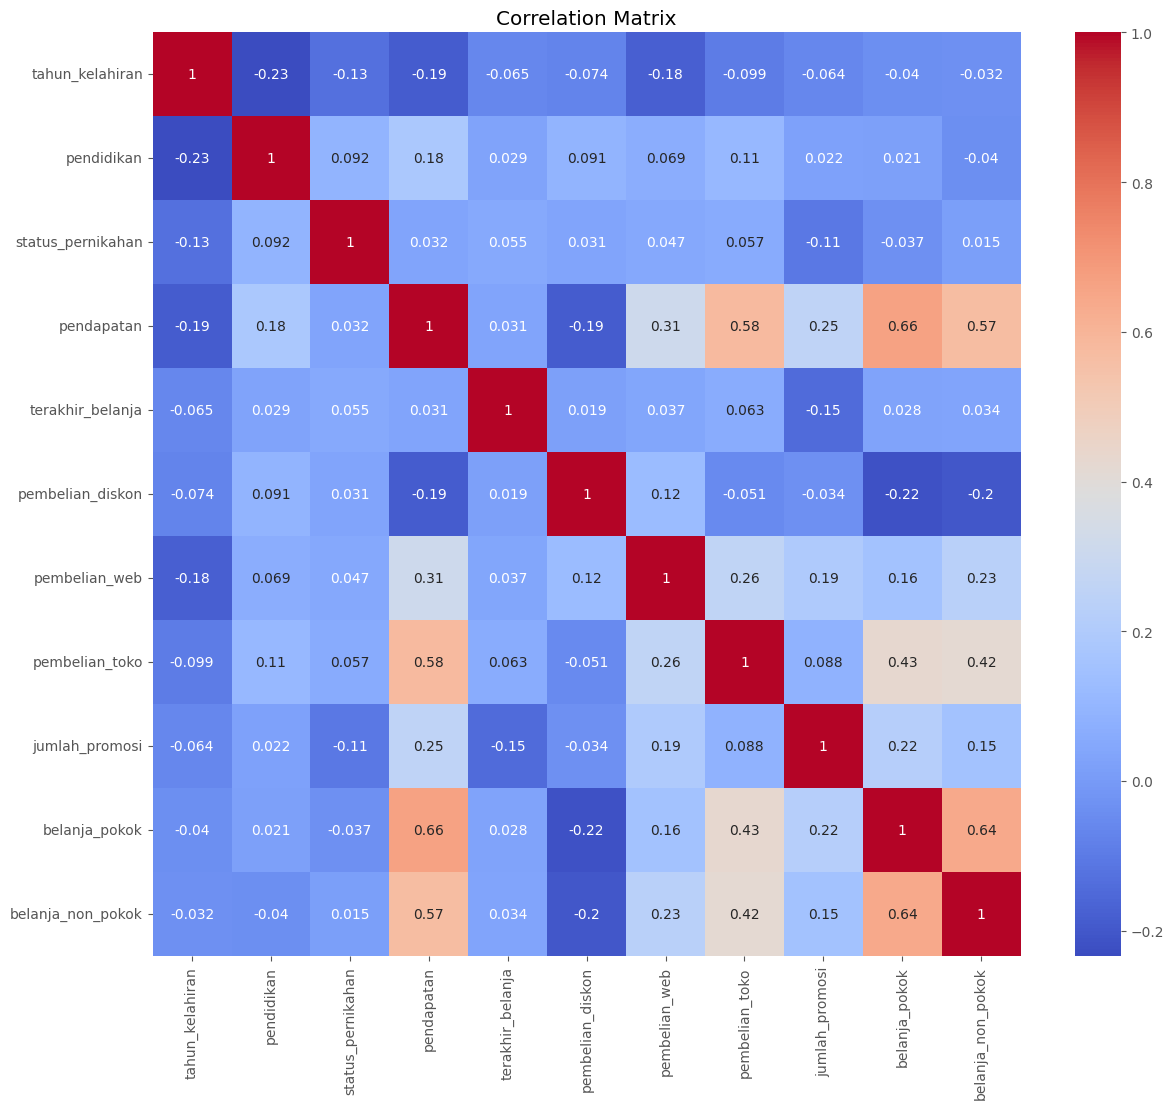

In [119]:
# Menghitung matriks korelasi
corr_matrix = train.corr()

# Membuat plot heatmap 
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [120]:
X = train.drop(columns = ['jumlah_promosi'], axis = 1)
y = train['jumlah_promosi']

In [121]:
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter Tuning Optuna

In [122]:
# def objective(trial):
#     # Define the hyperparameters to optimize for each classifier
#     rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
#     rf_max_depth = trial.suggest_int("rf_max_depth", 3, 20)
#     rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 20)
#     rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 20)
    
#     et_n_estimators = trial.suggest_int("et_n_estimators", 100, 1000)
#     et_max_depth = trial.suggest_int("et_max_depth", 3, 20)
#     et_min_samples_split = trial.suggest_int("et_min_samples_split", 2, 20)
#     et_min_samples_leaf = trial.suggest_int("et_min_samples_leaf", 1, 20)
    
#     xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 1000, )
#     xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 10)
#     xgb_learning_rate = trial.suggest_loguniform("xgb_learning_rate", 0.01, 0.1)
#     xgb_gamma = trial.suggest_loguniform('xgb_gamma', 0.01, 1.0),
#     xgb_min_child_weight = trial.suggest_int('xgb_min_child_weight', 1, 5),
#     xgb_colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#     xgb_subsample =  trial.suggest_uniform('subsample', 0.5, 1.0),
    
#     # Create individual classifiers with the suggested hyperparameters
#     rf = RandomForestClassifier(n_estimators=rf_n_estimators,
#                                 max_depth=rf_max_depth,
#                                 min_samples_split=rf_min_samples_split,
#                                 min_samples_leaf=rf_min_samples_leaf,
#                                 random_state=42)
    
#     et = ExtraTreesClassifier(n_estimators=et_n_estimators,
#                               max_depth=et_max_depth,
#                               min_samples_split=et_min_samples_split,
#                               min_samples_leaf=et_min_samples_leaf,
#                               random_state=42)
    
#     xgb = XGBClassifier(n_estimators=xgb_n_estimators,
#                         max_depth=xgb_max_depth,
#                         learning_rate=xgb_learning_rate,
#                         random_state=42)
    
#     # Construct the VotingClassifier with the individual classifiers
#     estimators = [('rf', rf), ('et', et), ('xgb', xgb)]
#     voting = trial.suggest_categorical("voting", ["hard", "soft"])
    
#     model = VotingClassifier(estimators=estimators, voting=voting)
    
#     # Use stratified k-fold cross-validation for evaluation
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=skf, n_jobs=-1)
    
#     # Return the mean F1 score of the model
#     return scores.mean()

# # Create an Optuna study
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(study_name="voting_classifier", direction="maximize", sampler=sampler)

# # Optimize the objective function
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# # Get the best trial and its parameters
# best_trial = study.best_trial
# best_params = best_trial.params

# # Construct the VotingClassifier with the best parameters
# rf_best = RandomForestClassifier(n_estimators=best_params["rf_n_estimators"],
#                                  criterion = 'log_loss',
#                                  max_depth=best_params["rf_max_depth"],
#                                  min_samples_split=best_params["rf_min_samples_split"],
#                                  min_samples_leaf=best_params["rf_min_samples_leaf"],
#                                  random_state=42)

# et_best = ExtraTreesClassifier(n_estimators=best_params["et_n_estimators"],
#                                criterion = 'log_loss',
#                                max_depth=best_params["et_max_depth"],
#                                min_samples_split=best_params["et_min_samples_split"],
#                                min_samples_leaf=best_params["et_min_samples_leaf"],
#                                random_state=42)

# xgb_best = XGBClassifier(n_estimators=best_params["xgb_n_estimators"],
#                          max_depth=best_params["xgb_max_depth"],
#                          learning_rate=best_params["xgb_learning_rate"],
#                          random_state=42)

# best_estimators = [('rf', rf_best), ('et', et_best), ('xgb', xgb_best)]
# best_voting = best_params["voting"]

# best_model = VotingClassifier(estimators=best_estimators, voting=best_voting)

# # Train the best VotingClassifier on the full training data
# best_model.fit(X_train, y_train)

# # Evaluate the best model on the test data
# y_pred = best_model.predict(X_test)
# f1_macro = f1_score(y_test, y_pred, average='macro')

# print("Best F1 Macro Score on Test Set:", f1_macro)
# print("Best Parameters:")
# print(best_params)

In [123]:

# # Define the objective function for optimization
# def objective(trial):
#     # Define the hyperparameters to optimize for each classifier
#     rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
#     rf_max_depth = trial.suggest_int("rf_max_depth", 3, 20)
#     rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 20)
#     rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 20)
    
#     et_n_estimators = trial.suggest_int("et_n_estimators", 100, 1000)
#     et_max_depth = trial.suggest_int("et_max_depth", 3, 20)
#     et_min_samples_split = trial.suggest_int("et_min_samples_split", 2, 20)
#     et_min_samples_leaf = trial.suggest_int("et_min_samples_leaf", 1, 20)
    
#     xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 1000)
#     xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 10)
#     xgb_learning_rate = trial.suggest_loguniform("xgb_learning_rate", 0.01, 0.1)
#     xgb_gamma = trial.suggest_loguniform('xgb_gamma', 0.01, 1.0)
#     xgb_min_child_weight = trial.suggest_int('xgb_min_child_weight', 1, 5)
#     xgb_colsample_bytree = trial.suggest_uniform('xgb_colsample_bytree', 0.5, 1.0)
#     xgb_subsample = trial.suggest_uniform('xgb_subsample', 0.5, 1.0)
    
#     # Create individual classifiers with the suggested hyperparameters
#     rf = RandomForestClassifier(n_estimators=rf_n_estimators,
#                                 max_depth=rf_max_depth,
#                                 criterion = 'log_loss',
#                                 min_samples_split=rf_min_samples_split,
#                                 min_samples_leaf=rf_min_samples_leaf,
#                                 random_state=42)
    
#     et = ExtraTreesClassifier(n_estimators=et_n_estimators,
#                               max_depth=et_max_depth,
#                               criterion = 'log_loss',
#                               min_samples_split=et_min_samples_split,
#                               min_samples_leaf=et_min_samples_leaf,
#                               random_state=42)
    
#     xgb = XGBClassifier(n_estimators=xgb_n_estimators,
#                         max_depth=xgb_max_depth,
#                         learning_rate=xgb_learning_rate,
#                         gamma=xgb_gamma,
#                         min_child_weight=xgb_min_child_weight,
#                         colsample_bytree=xgb_colsample_bytree,
#                         subsample=xgb_subsample,
#                         random_state=42)
    
#     # Construct the VotingClassifier with the individual classifiers
#     estimators = [('rf', rf), ('et', et), ('xgb', xgb)]
#     voting = trial.suggest_categorical("voting", ["hard", "soft"])
    
#     model = VotingClassifier(estimators=estimators, voting=voting)
    
#     # Use stratified k-fold cross-validation for evaluation
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=skf, n_jobs=-1)
    
#     # Return the mean F1 score of the model
#     return scores.mean()

# # Create an Optuna study
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(study_name="voting_classifier", direction="maximize", sampler=sampler)

# # Optimize the objective function
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# # Get the best trial and its parameters
# best_trial = study.best_trial
# best_params = best_trial.params

# # Construct the VotingClassifier with the best parameters
# rf_best = RandomForestClassifier(n_estimators=best_params["rf_n_estimators"],
#                                  max_depth=best_params["rf_max_depth"],
#                                  min_samples_split=best_params["rf_min_samples_split"],
#                                  min_samples_leaf=best_params["rf_min_samples_leaf"],
#                                  criterion='log_loss',  # Specify the criterion (e.g., 'gini' or 'entropy')
#                                  random_state=42)

# et_best = ExtraTreesClassifier(n_estimators=best_params["et_n_estimators"],
#                                max_depth=best_params["et_max_depth"],
#                                min_samples_split=best_params["et_min_samples_split"],
#                                min_samples_leaf=best_params["et_min_samples_leaf"],
#                                criterion='log_loss',  # Specify the criterion (e.g., 'gini' or 'entropy')
#                                random_state=42)

# xgb_best = XGBClassifier(n_estimators=best_params["xgb_n_estimators"],
#                          max_depth=best_params["xgb_max_depth"],
#                          learning_rate=best_params["xgb_learning_rate"],
#                          gamma=best_params["xgb_gamma"],
#                          min_child_weight=best_params["xgb_min_child_weight"],
#                          colsample_bytree=best_params["xgb_colsample_bytree"],
#                          subsample=best_params["xgb_subsample"],
#                          random_state=42)

# best_estimators = [('rf', rf_best), ('et', et_best), ('xgb', xgb_best)]
# best_voting = best_params["voting"]

# best_model = VotingClassifier(estimators=best_estimators, voting=best_voting)

# # Train the best VotingClassifier on the full training data
# best_model.fit(X_train, y_train)

# # Evaluate the best model on the test data
# y_pred = best_model.predict(X_test)
# f1_macro = f1_score(y_test, y_pred, average='macro')

# print("Best F1 Macro Score on Test Set:", f1_macro)
# print("Best Parameters:")
# print(best_params)


In [131]:
%%time
def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)

    # Number of features to consider at every split
    max_features = trial.suggest_int(name="max_features", low=1, high=10)

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=100)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=32)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
    
    model = ExtraTreesClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
                                    min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
                                    max_features =  max_features, random_state =  42, n_jobs =  -1)
    
    score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return score.mean() 

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
    
optuna.visualization.plot_optimization_history(study)


Best trial: 13. Best value: 0.712564: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]

Number of finished trials:  100
Best trial:
  Value:  0.7125640717670496
  Params: 
    n_estimators: 403
    max_features: 8
    max_depth: 71
    min_samples_split: 2
    min_samples_leaf: 1
CPU times: total: 1.06 s
Wall time: 2min 34s


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.571706413346156, 0.0586154558251024, 0.5978912846900473,
                    0.44788002020940293, 0.2725405038890201, 0.48602997308377116,
                    0.18324973607861803, 0.38899171824759393, 0.44920078188179036,
                    0.5027625451541324, 0.407567259924297, 0.6866133875457419,
                    0.6990743306453583, 0.7125640717670496, 0.7054043327914765,
                    0.4998805243865931, 0.3867041314348279, 0.40515384197239845,
                    0.48225927597654356, 0.6054026989309141, 0.523079086567497,
                    0.6941689017024207, 0.6639380339634149, 0.6371413836656056,
                    0.5348779196707667, 0.48453436563363256, 0.3496494354398373,
                    0.6687021981782214, 0.5660367737831296, 0.36938181469859416,
                    0.5802520132321201, 0.6932637898948633, 0.6789646021975027,
                    0.5884597331378709, 0.6352462796589858, 0.5695361667739975,
                    0.4071685899544482, 0.6429166188352028, 0.6628047015253737,
                    0.4715005378740985, 0.07870552184910619, 0.6932637898948633,
                    0.6653676170247772, 0.6021669657015479, 0.6935519864741374,
                    0.6923040909604528, 0.5576131556403731, 0.3287505084481453,
                    0.5849321201278914, 0.6925980052104432, 0.5162833412408759,
                    0.6764614412029366, 0.6501358097870271, 0.6691294155686138,
                    0.6879436847979569, 0.6402059362565112, 0.6024024708401889,
                    0.4409104121192172, 0.60695329111685, 0.5689557887101816,
                    0.6535190961076127, 0.6958714312692005, 0.6990986249760701,
                    0.668172858696749, 0.6940562173151804, 0.7040382825949287,
                    0.4201544340525974, 0.6175634161722225, 0.6618952643917062,
                    0.5927622735608696, 0.6347989869228554, 0.6941417402453011,
                    0.6930333645090869, 0.6650613629496265, 0.7112050033160762,
                    0.6331873120218073, 0.38215979611643647, 0.6920663015440585,
                    0.6852523503279255, 0.5798204967803811, 0.6201894167805507,
                    0.6808308922337744, 0.6958766187242624, 0.6958766187242624,
                    0.6870117515950537, 0.6345298710998662, 0.6950608656908701,
                    0.6646445070794831, 0.6735138212888129, 0.6374340328497672,
                    0.5629678125190615, 0.5423198295350355, 0.6922619482904724,
                    0.6923644640116029, 0.6544642737898547, 0.6743094381727255,
                    0.6071902046701297, 0.7085421254456433, 0.6703182200259759,
                    0.6910767780075956]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.5717064133461

### Modelling Part 1

### Modelling Part 2

In [125]:
# md1 = ExtraTreesClassifier(n_estimators = 407, max_features = 10, max_depth = 62, min_samples_split = 2,   
#                                              min_samples_leaf = 1, criterion = 'log_loss', random_state = 1)

# md2 = HistGradientBoostingClassifier(max_iter = 755, learning_rate = 0.08069194222134556, l2_regularization = 0.004071819616198791,
#                                                        max_depth = 38, max_leaf_nodes = 30, min_samples_leaf = 4, loss = 'log_loss', max_bins =  255, 
#                                                        early_stopping =  False, random_state =  1)

# md3 = XGBClassifier(n_estimators = 241, learning_rate = 0.027071426847753828, max_depth = 23, subsample = 0.826267822451126,
#                                        min_child_weight = 1, gamma = 0.07899077336556067, colsample_bytree = 0.7273085926052265,
#                                        reg_alpha = 0.0011669044708923562, reg_lambda = 1.7546953633442173e-05, random_state =  1)

### Model 1.1

In [134]:
# model = RandomForestClassifier(n_estimators = 551, max_features = 9, max_depth = 48, min_samples_split = 2,
#                                                 min_samples_leaf = 1,random_state = 1, criterion = 'log_loss', n_jobs = -1)

model = ExtraTreesClassifier(
    n_estimators=642,
    max_features=8,
    max_depth=62,
    min_samples_split=3,
    min_samples_leaf=1,
    criterion = 'log_loss',
    random_state = 1, 
    n_jobs =  -1
)

# model = XGBClassifier(n_estimators = 241, learning_rate = 0.027071426847753828, max_depth = 23, subsample = 0.826267822451126,
#                                        min_child_weight = 1, gamma = 0.07899077336556067, colsample_bytree = 0.7273085926052265,
#                                        reg_alpha = 0.0011669044708923562, reg_lambda = 1.7546953633442173e-05, random_state =  1)

# model = HistGradientBoostingClassifier(max_iter = 755, learning_rate = 0.08069194222134556, l2_regularization = 0.004071819616198791,
#                                                        max_depth = 38, max_leaf_nodes = 30, min_samples_leaf = 4, loss = 'log_loss', max_bins =  255, 
#                                                        early_stopping =  False, random_state =  1)

model.fit(X, y)
y_pred = model.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))
submission = model.predict(test)

F1:  1.0


In [133]:
# model = ExtraTreesClassifier(
#     n_estimators= 403,
#     max_features= 8,
#     max_depth= 71,
#     min_samples_split= 2,
#     min_samples_leaf= 1,
#     criterion = 'log_loss',
#     random_state = 42, 
#     n_jobs =  -1
# )

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print('F1: ', f1_score(y_test, y_pred, average='macro'))
# submission = model.predict(test)

F1:  0.7260354329785198


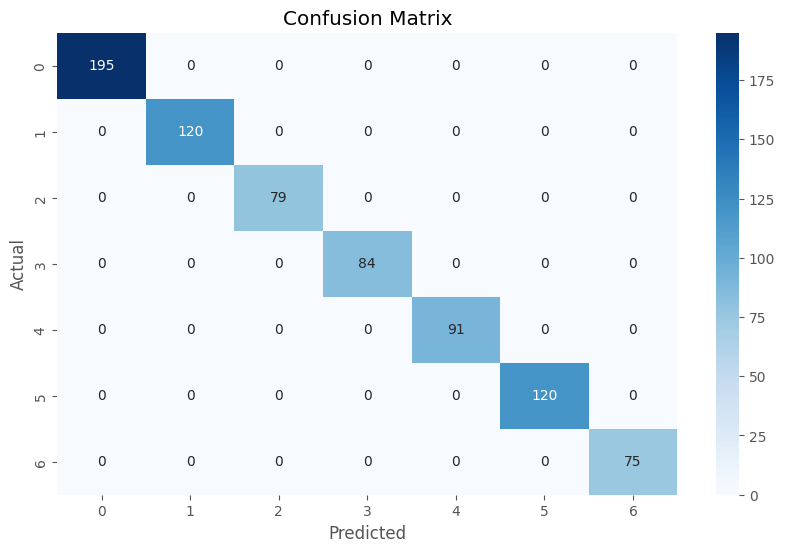

In [135]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

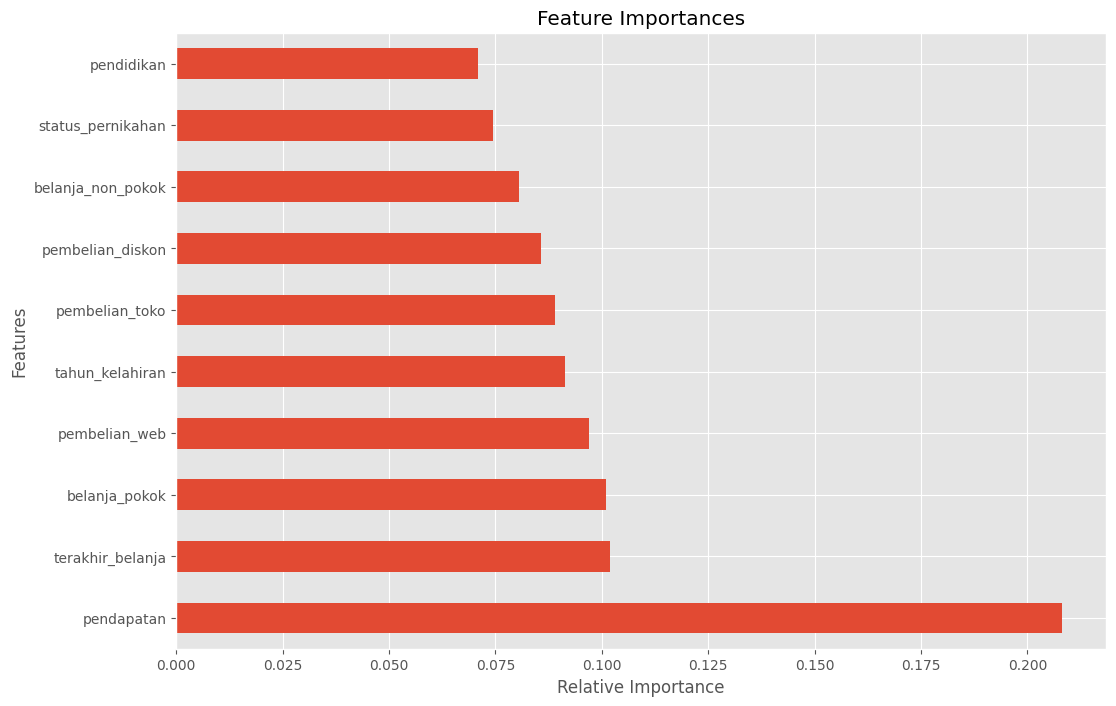

In [136]:
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

In [129]:
submission_format['jumlah_promosi'] = pd.DataFrame(submission)
submission_format.to_csv('submission_y.csv',index = False)